In [ ]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [ ]:
!unzip /content/drive/MyDrive/pokemon.zip

Streaming output truncated to the last 5000 lines.
 extracting: pokemon/601/601-0.png   
 extracting: pokemon/601/601-49.png  
 extracting: pokemon/601/601-55.png  
 extracting: pokemon/601/601-45.png  
 extracting: pokemon/601/601-27.png  
 extracting: pokemon/601/601-78.png  
 extracting: pokemon/601/601-41.png  
 extracting: pokemon/601/601-8.png   
 extracting: pokemon/601/601-43.png  
 extracting: pokemon/601/601-20.png  
 extracting: pokemon/601/601-58.png  
 extracting: pokemon/601/601-19.png  
 extracting: pokemon/601/601-28.png  
 extracting: pokemon/601/601-69.png  
 extracting: pokemon/601/601-75.png  
 extracting: pokemon/601/601-17.png  
 extracting: pokemon/601/601-1.png   
 extracting: pokemon/601/601-30.png  
 extracting: pokemon/601/601-26.png  
 extracting: pokemon/601/601-21.png  
 extracting: pokemon/601/601-76.png  
 extracting: pokemon/601/601-5.png   
 extracting: pokemon/601/601-62.png  
 extracting: pokemon/601/601-4.png   
 extracting: pokemon/601/601-50.png  

In [ ]:
import os
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

In [ ]:
class Discriminator(nn.Module):
  def __init__(self,channel_img,feature_d):
    super(Discriminator,self).__init__()
    self.disc=nn.Sequential(
            nn.Conv2d(channel_img,feature_d,4,2,1),
            nn.LeakyReLU(0.2),
            self._block(feature_d,feature_d*2,4,2,1),#16
            self._block(feature_d*2,feature_d*4,4,2,1),#8
            self._block(feature_d*4,feature_d*8,4,2,1),#4
            nn.Conv2d(feature_d*8,1,4,1,0),
            nn.Sigmoid()
        )
  def _block(self,in_channel,out_channel,kernal_size,stride,padding):
    return nn.Sequential(nn.Conv2d(in_channel,out_channel,kernal_size,stride,padding,bias=False),
    nn.BatchNorm2d(out_channel),
    nn.LeakyReLU(0.2)
    )
  def forward(self,x):
    return self.disc(x)


class Generator(nn.Module):
  def __init__(self,z_dim,channel_img,feature_g):
    super(Generator,self).__init__()
    self.gen= nn.Sequential(
        self._block(z_dim,feature_g*16,4,2,0),#4
        self._block(feature_g*16,feature_g*8,4,2,1),#8
        self._block(feature_g*8,feature_g*4,4,2,1),#16
        self._block(feature_g*4,feature_g*2,4,2,1),#32
        nn.ConvTranspose2d(feature_g*2,channel_img,4,2,1), #N*channel_img*64*64
        nn.Tanh()
    )
  def _block(self,in_channel,out_channel,kernal_size,stride,padding):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channel,out_channel,kernal_size,stride,padding,bias=False),
        nn.BatchNorm2d(out_channel),
        nn.ReLU()
    )
  def forward(self,x):
    return self.gen(x)

In [ ]:
class PokemonDataset(Dataset):
  def __init__(self,path,transform=None):
    self.data=ImageFolder(path,transform=transform)

  def __len__(self):
    return len(self.data)

  def __getitem__(self,idx):
    return self.data[idx]

  def classes(self):
    return self.data.classes

In [ ]:
device =torch.device("cuda" if torch.cuda.is_available() else "cpu")
lr=2e-4
batch_size=128
z_dim=100
img_size=64
channel_image=3
feature_d=64
feature_g=64
num_epoch=5

transform = transforms.Compose(
    [
      transforms.Resize((64,64)),
      transforms.ToTensor(),
      transforms.Normalize(
        [0.5 for _ in range(channel_image)],[0.5 for _ in range(channel_image)]),
    ]
)

In [ ]:
from torchvision import datasets
from torchvision.datasets import ImageFolder
data_path = '/content/pokemon'
dataset=PokemonDataset(data_path,transform=transform)
dataloader=DataLoader(dataset,batch_size=128,shuffle=True)
for X,y in dataloader:
  print(X.shape)
  break

torch.Size([128, 3, 64, 64])


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [ ]:
print(len(dataloader))

def intialize_weight(model):
  for m in model.modules():
    if isinstance(m,(nn.Conv2d,nn.ConvTranspose2d,nn.BatchNorm2d)):
      nn.init.normal_(m.weight.data,0.0,0.02)

from torch.utils.tensorboard import SummaryWriter
gen=Generator(z_dim,channel_image,feature_g).to(device)
des=Discriminator(channel_image,feature_d).to(device)
intialize_weight(gen)
intialize_weight(des)
opt_gen=torch.optim.SGD(gen.parameters(),lr=lr,betas=(0.5,0.999))
opt_des=torch.optim.SGD(des.parameters(),lr=lr,betas=(0.5,0.999))
criterion=nn.BCELoss()
fixed_noise=torch.randn(batch_size,z_dim,1,1).to(device)
writer_fake=SummaryWriter(f'runs/fake')
writer_real=SummaryWriter(f'runs/real')
step=0
gen.train()
des.train()
image,label=dataset[10]
print(image.shape)

318
torch.Size([3, 64, 64])


In [ ]:
z = torch.randn(1, 100, 1, 1).to(device)
print(gen(z).shape)
print(des(gen(z)))

torch.Size([1, 3, 64, 64])
tensor([[[[0.5097]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


In [ ]:
import torchvision
for epochs in range(num_epoch):
  for batch_idx,(real,_) in enumerate(dataloader):
    real=real.to(device)
    z=torch.randn(batch_size,z_dim,1,1).to(device)
    disc_real=des(real).reshape(-1)
    loss_real=criterion(disc_real,torch.ones_like(disc_real))
    fake=gen(z)
    disc_fake=des(fake).reshape(-1)
    loss_fake=criterion(disc_fake,torch.zeros_like(disc_fake))
    loss_disc=(loss_real+loss_fake)/2
    opt_des.zero_grad()
    loss_disc.backward(retain_graph=True)
    opt_des.step()
    output=des(fake).reshape(-1)
    loss_gen=criterion(output,torch.ones_like(output))
    opt_gen.zero_grad()
    loss_gen.backward()
    opt_gen.step()
    if batch_idx%100==0:
      print(f'Epoch [{epochs}/{num_epoch}] Batch {batch_idx}/{len(dataloader)} Loss D: {loss_disc:.4f}, Loss G: {loss_gen:.4f}')
    with torch.no_grad():
      fake=gen(z)
      image_grid_real=torchvision.utils.make_grid(real[:32],normalize=True)
      image_grid_fake=torchvision.utils.make_grid(fake[:32],normalize=True)
      writer_real.add_image('real',image_grid_real,global_step=step)
      writer_fake.add_image('fake',image_grid_fake,global_step=step)
      step+=1

Epoch [0/5] Batch 0/318 Loss D: 1.9940, Loss G: 0.8186
Epoch [0/5] Batch 100/318 Loss D: 0.2820, Loss G: 1.5988
Epoch [0/5] Batch 200/318 Loss D: 0.1279, Loss G: 2.6314
Epoch [0/5] Batch 300/318 Loss D: 0.0726, Loss G: 3.1575
Epoch [1/5] Batch 0/318 Loss D: 0.0641, Loss G: 3.2287
Epoch [1/5] Batch 100/318 Loss D: 0.2381, Loss G: 2.1462
Epoch [1/5] Batch 200/318 Loss D: 0.2983, Loss G: 1.5444
Epoch [1/5] Batch 300/318 Loss D: 0.2595, Loss G: 3.2146
Epoch [2/5] Batch 0/318 Loss D: 0.3448, Loss G: 2.0443
Epoch [2/5] Batch 100/318 Loss D: 0.1974, Loss G: 4.2944
Epoch [2/5] Batch 200/318 Loss D: 0.3308, Loss G: 6.2929
Epoch [2/5] Batch 300/318 Loss D: 0.0972, Loss G: 4.3936
Epoch [3/5] Batch 0/318 Loss D: 0.3331, Loss G: 2.2399
Epoch [3/5] Batch 100/318 Loss D: 0.2602, Loss G: 3.9847
Epoch [3/5] Batch 200/318 Loss D: 0.1624, Loss G: 2.9172
Epoch [3/5] Batch 300/318 Loss D: 0.1856, Loss G: 3.5819
Epoch [4/5] Batch 0/318 Loss D: 0.3127, Loss G: 2.9480
Epoch [4/5] Batch 100/318 Loss D: 0.2770,

torch.Size([16, 3, 64, 64])


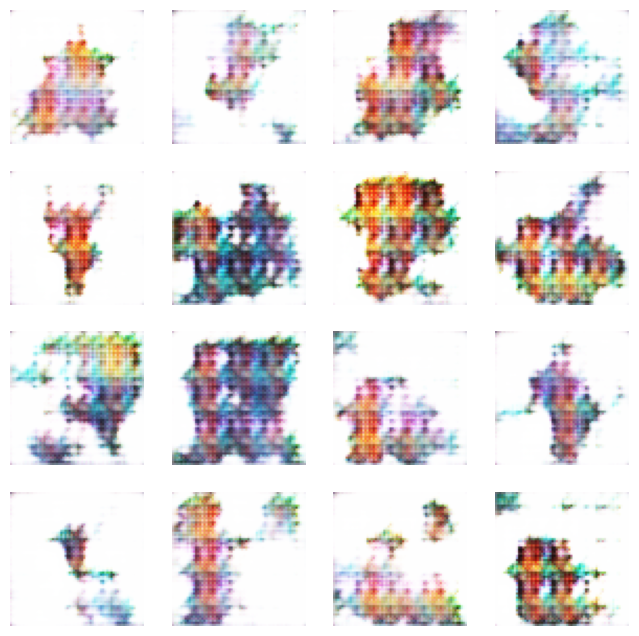

In [ ]:
import matplotlib.pyplot as plt
def generate_and_visualize(generator, num_samples=16, noise_dim=100):
    noise = torch.randn(num_samples, noise_dim ,1,1).to(device)
    with torch.no_grad():
        fake_images = generator(noise)
    print(fake_images.shape)
    fake_images = fake_images.view(num_samples, 3, 64, 64).permute(0, 2, 3, 1).cpu().numpy()

    fig, axes = plt.subplots(4, 4, figsize=(8, 8))
    axes = axes.flatten()
    for i in range(num_samples):
        axes[i].imshow((fake_images[i] + 1) / 2)
        axes[i].axis('off')
    plt.show()

generate_and_visualize(gen, num_samples=16, noise_dim=100)